# $\frac{P(Viagra | Spam)P(Spam)}{P(Viagra)}$

# $\frac{(65/370000)(0.55)}{75/7000000}$




In [1]:
"""from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())"""

'from google.colab import auth\nauth.authenticate_user()\n\nimport gspread\nfrom oauth2client.client import GoogleCredentials\n\ngc = gspread.authorize(GoogleCredentials.get_application_default())'

# Notebooks Imports

In [2]:
from os import walk
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from collections import Counter

%matplotlib inline

# Constants

In [3]:
EXAMPLE_FILE = "SpamData/SpamData/01_Processing/practice_email.txt"

SPAM_1_PATH = "SpamData/SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH = "SpamData/SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH = "SpamData/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH = "SpamData/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = "SpamData/SpamData/01_Processing/email-text-data.json"
WORD_ID_FILE = "SpamData/SpamData/01_Processing/word-by-id.csv"

TRAINING_DATA_FILE = "SpamData/SpamData/02_Training/train-data.txt"
TEST_DATA_FILE = "SpamData/SpamData/02_Training/test-data.txt"

WHALE_FILE = "SpamData/SpamData/01_Processing/wordcloud_resources/whale-icon.png"
SKULL_FILE = "SpamData/SpamData/01_Processing/wordcloud_resources/skull-icon.png"

# Reading Files

In [4]:
stream = open(EXAMPLE_FILE, encoding="latin-1")
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [5]:
import sys
import os
sys.getfilesystemencoding()

'utf-8'

In [6]:
stream = open(EXAMPLE_FILE, encoding="latin-1")

is_body = False
lines = []

for line in stream:
  if is_body:
    lines.append(line)
  elif line == "\n":
    is_body = True 

stream.close()

email_body = "\n".join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [7]:
def generate_squares(N):

    for my_number in range(N):
        yield (my_number + 3) ** 2

for i in generate_squares(5):
    print(i, end=" -> ")

9 -> 16 -> 25 -> 36 -> 49 -> 

#Email body extraction

In [8]:
def email_body_generator(path):

  for root, dirnames, filenames in walk(path):
    for file_name in filenames:

      filepath = join(root, file_name)

      stream = open(filepath, encoding="latin-1")

      is_body = False
      lines = []

      for line in stream:
        if is_body:
          lines.append(line)
        elif line == "\n":
          is_body = True 

      stream.close()

      email_body = "\n".join(lines)
      yield file_name, email_body


In [9]:
def df_from_directory(path, classification):
  rows = []
  row_names = []

  for file_name, email_body in email_body_generator(path):
    rows.append({"MESSAGE": email_body, "CATEGORY": classification})
    row_names.append(file_name)

  return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

/tmp/ipykernel_4238/2860214245.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [11]:
spam_emails.shape

(1898, 2)

In [12]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.head()

/tmp/ipykernel_4238/3198151448.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))


,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [13]:
ham_emails.shape

(3901, 2)

In [14]:
data = pd.concat([spam_emails, ham_emails])
print("Shape of entire dataframe is ", data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


# Data Cleaning: Cheking for Missing Values

In [15]:
# check if any message bodies are null
data["MESSAGE"].isnull().values.any()

False

In [16]:
# check if there are empty emails (string length zero)
data.MESSAGE.str.len().values.any()

True

In [17]:
(data.MESSAGE.str.len() == 0).sum()

3

In [18]:
# Check the number of entries with null/None values
data["MESSAGE"].isnull().sum()

0

### Locate empty emails

In [19]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [20]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [21]:
#data.index.get_loc(".DS_Store")

# Remove System File Entries from Dataframe

In [22]:
# removing line
data = data.drop(["cmds"])

In [23]:
type(data)

pandas.core.frame.DataFrame

In [24]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [25]:
document_ids = range(0, len(data.index))
data["DOC_ID"] = document_ids

In [26]:
data.DOC_ID

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: DOC_ID, Length: 5796, dtype: int64

In [27]:
data["FILE_NAME"] = data.index
data.set_index("DOC_ID", inplace=True)

In [28]:
data

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676


In [29]:
data.shape

(5796, 3)

# Save to File using Pandas

In [30]:
data.to_json(DATA_JSON_FILE)

In [31]:
data

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676


# 

In [32]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [33]:
amount_of_ham = data.CATEGORY.value_counts()[0]
amount_of_spam = data.CATEGORY.value_counts()[1]

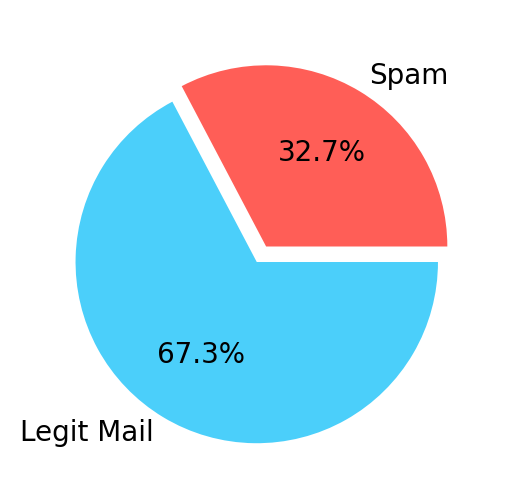

In [34]:
category_names = ["Spam", "Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ["#ff5e57", "#4bcffa"]

plt.figure(figsize=(3,3), dpi=200)
plt.pie(sizes, labels=category_names, textprops={"fontsize": 10}, autopct="%1.1f%%", colors=custom_colours, explode=[0,0.10])
plt.show()

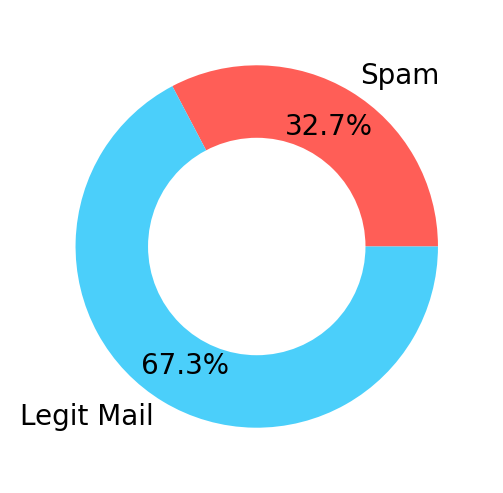

In [35]:
category_names = ["Spam", "Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ["#ff5e57", "#4bcffa"]

plt.figure(figsize=(3,3), dpi=200)
plt.pie(sizes, labels=category_names, textprops={"fontsize": 10}, autopct="%1.1f%%", colors=custom_colours, pctdistance=0.77)

centre_circle = plt.Circle((0, 0), radius=0.6, fc="White")
plt.gca().add_artist(centre_circle)
plt.show()

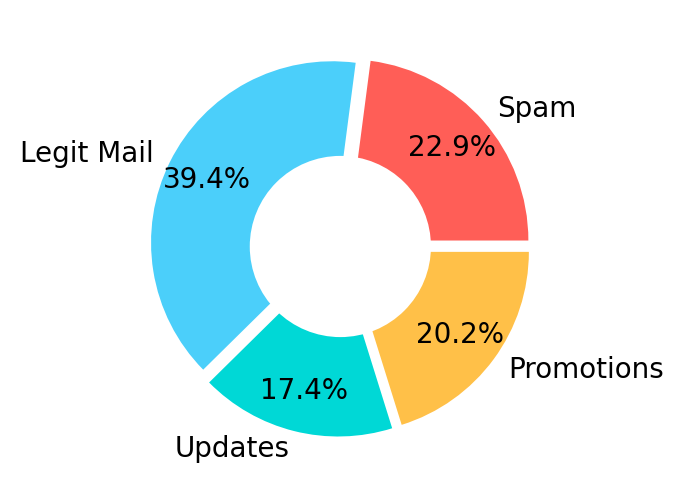

In [36]:
category_names = ["Spam", "Legit Mail", "Updates", "Promotions"]
sizes = [25, 43, 19, 22]
custom_colours = ["#ff5e57", "#4bcffa", "#00d8d6", "#ffc048"]
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(3,3), dpi=200)
plt.pie(sizes, labels=category_names, textprops={"fontsize": 10}, autopct="%1.1f%%", colors=custom_colours, pctdistance=0.77, explode=offset)

centre_circle = plt.Circle((0, 0), radius=0.5, fc="White")
plt.gca().add_artist(centre_circle)
plt.show()

# Natural Language Processing - NLP
## Text Pre-Processing

In [37]:
msg = "All work and no play makes Jack a dull boy"
msg.lower()

'all work and no play makes jack a dull boy'

In [38]:
msg.upper()

'ALL WORK AND NO PLAY MAKES JACK A DULL BOY'

In [39]:
msg.capitalize()

'All work and no play makes jack a dull boy'

# Download the NLTK Resources (Tokenizer & Stopwords)

In [40]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/magalhaes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [41]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/magalhaes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
nltk.download("shakespeare")
nltk.download("gutenberg")

[nltk_data] Downloading package shakespeare to
[nltk_data]     /home/magalhaes/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/magalhaes/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

## Tokenising

In [43]:
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

## Removing Stop Words

In [44]:
english = stopwords.words("english")
len(english)
english

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [45]:
portuguese = stopwords.words("portuguese")
len(portuguese)
portuguese

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

In [46]:
russian = stopwords.words("russian")
print(len(russian))
russian

151


['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [47]:
stop_words = set(stopwords.words("english"))

In [48]:
if "hello" not in stop_words: print("Nope. Not in here")

Nope. Not in here


In [49]:
msg = "All work and no play makes Jack a dull boy. To be or not to be"
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
  if word not in stop_words:
    filtered_words.append(word)

In [50]:
filtered_words

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.']

## Words Stems and Stemming

In [51]:
msg = "All work and no play makes Jack a dull boy. To be or not to be. Nobody expects the Spanish Inquisition!"
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer("english")

filtered_words = []
for word in words:
  if word not in stop_words:
    stemmed_word = stemmer.stem(word)
    filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


# Removing Punctuation

In [52]:
msg = "All work and no play makes Jack a dull boy. To be or not to be. Nobody expects the Spanish Inquisition!"
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer("english")

filtered_words = []
for word in words:
  if word not in stop_words and word.isalpha():
    stemmed_word = stemmer.stem(word)
    filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags from Emails

In [53]:
soup = BeautifulSoup(data.at[2, "MESSAGE"], "html.parser")

In [54]:
soup.get_text()

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

## Functions for Email Processing

In [55]:
def clean_message(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words("english"))):

  # Converts to Lower Case and splits up the words
  words = word_tokenize(message.lower())

  filtered_words = []

  for word in words:
    # Removes the stop words and ponctuation
    if word not in stop_words and word.isalpha():
      filtered_words.append(stemmer.stem(word))

  return filtered_words

In [56]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [57]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words("english"))):

  soup = BeautifulSoup(message, "html.parser")
  cleaned_text = soup.get_text()

  # Converts to Lower Case and splits up the words
  words = word_tokenize(cleaned_text.lower())

  filtered_words = []

  for word in words:
    # Removes the stop words and ponctuation
    if word not in stop_words and word.isalpha():
      filtered_words.append(stemmer.stem(word))

  return filtered_words

In [58]:
clean_msg_no_html(data.at[2, "MESSAGE"])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [59]:
data.iloc[0:3]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c


In [60]:
first_emails = data.MESSAGE.iloc[1000:1003]

nested_list = first_emails.apply(clean_message)

In [61]:
# flat_list = []

# for sublist in nested_list:
#   for item in sublist:
#     flat_list.append(item)
flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

382

In [62]:
%%time

# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

/home/magalhaes/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 20.4 s, sys: 22.6 ms, total: 20.4 s
Wall time: 20.5 s


In [63]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

## Using Logic to Slice Dataframes

In [64]:
doc_ids_ham = data[data.CATEGORY == 0].index

In [65]:
doc_ids_spam = data[data.CATEGORY ==  1].index

## Subsetting a Series with an Index

In [66]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [67]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [68]:
# teacher way
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [69]:
# teacher way
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

In [70]:
# internet way that I found
word_count = Counter(pd.Series(flat_list_ham))

# count 10 most common words
word_count.most_common(10)

[('http', 7563),
 ('use', 3633),
 ('list', 2880),
 ('one', 2373),
 ('get', 2286),
 ('mail', 2255),
 ('would', 2003),
 ('like', 1931),
 ('messag', 1849),
 ('work', 1800)]

In [71]:
# internet way that I found
word_count = Counter(pd.Series(flat_list_spam))

# count 10 most common words
word_count.most_common(10)

[('http', 3097),
 ('email', 3090),
 ('free', 2585),
 ('click', 2058),
 ('receiv', 1989),
 ('list', 1971),
 ('get', 1914),
 ('pleas', 1852),
 ('busi', 1792),
 ('order', 1746)]

#Create Word Cloud

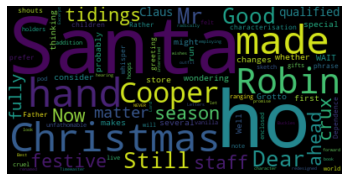

In [72]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [73]:
example_corpus = nltk.corpus.gutenberg.words("melville-moby_dick.txt")
len(example_corpus)

260819

In [74]:
word_list = ["".join(word) for word in example_corpus]
novel_as_string = " ".join(word_list)

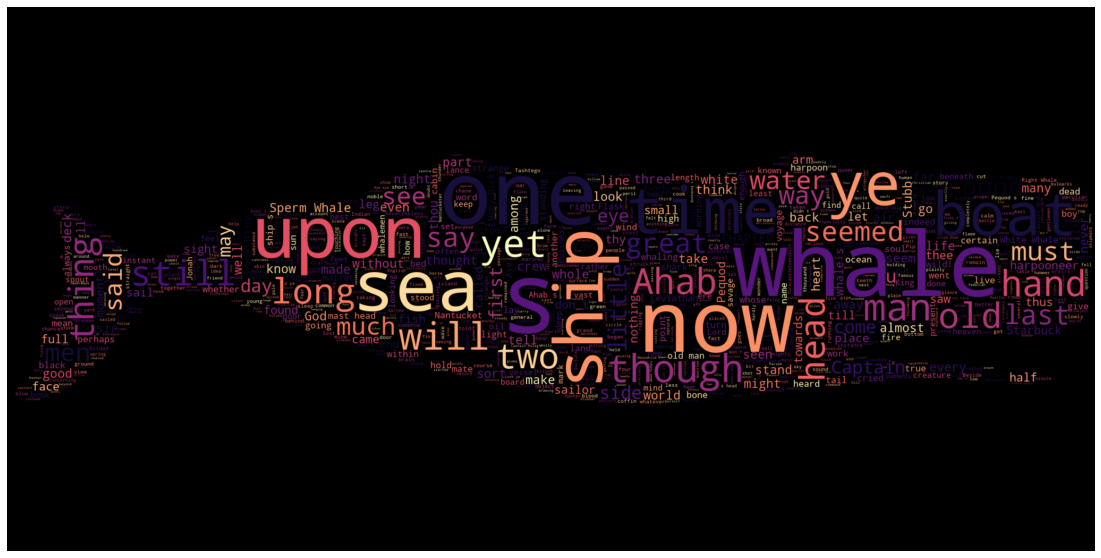

CPU times: user 10.2 s, sys: 153 ms, total: 10.4 s
Wall time: 10.4 s


In [75]:
%%time
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode="RGB", size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color="black", max_words=1000,
                       colormap="magma")
word_cloud.generate(novel_as_string)

plt.figure(figsize=[30, 10])
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

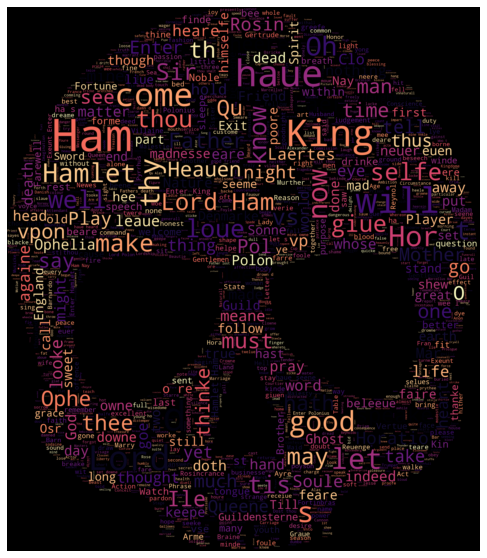

CPU times: user 58.4 s, sys: 733 ms, total: 59.2 s
Wall time: 59.2 s


In [76]:
%%time
hamlet_corpus = nltk.corpus.gutenberg.words("shakespeare-hamlet.txt")

word_list = ["".join(word) for word in hamlet_corpus]
novel_as_string = " ".join(word_list)

icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode="RGB", size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color="black", max_words=2000,
                       colormap="magma")
word_cloud.generate(novel_as_string)

plt.figure(figsize=[30, 10])
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generate Vocabulary & Dictionary

In [77]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

/home/magalhaes/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [78]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print("Number os unique words", unique_words.shape[0])
unique_words.head()

Number os unique words 27332


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [79]:
frequent_words = unique_words[0:VOCAB_SIZE]

In [80]:
frequent_words[:10]

http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64

## Create Vocabulary DataFrame with a WORD_ID

In [81]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({"VOCAB_WORD": frequent_words.index.values}, index=word_ids)
vocab.index.name = "WORD_ID"
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [82]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

## Exercise: Checcking if a Word is Part of the Vocabulary

In [83]:
# my resolution
words = ["machine", "learning", "fun", "learn", "data", "science", "app", "brewery"]
for word in words:
  print((vocab.VOCAB_WORD == word).values.any())

False
False
True
True
True
False
True
False


In [84]:
words = ["machine", "learning", "fun", "learn", "data", "science", "app", "brewery"]
for word in words:
  print(word in set(vocab.VOCAB_WORD))

False
False
True
True
True
False
True
False


In [85]:
"Machine" in set(vocab.VOCAB_WORD)

False

In [86]:
%%time

clean_email_lengths = []
for sublist in stemmed_nested_list:
  clean_email_lengths.append(len(sublist))
print("Number words in the longest email: ", max(clean_email_lengths))

Number words in the longest email:  7671
CPU times: user 2.68 ms, sys: 0 ns, total: 2.68 ms
Wall time: 2.48 ms


In [87]:
%%time

clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print("Number words in the longest email: ", max(clean_email_lengths))

Number words in the longest email:  7671
CPU times: user 1.33 ms, sys: 47 µs, total: 1.37 ms
Wall time: 1.32 ms


In [88]:
print("Email position in the list (and the data dataframe): ", np.argmax(clean_email_lengths))

Email position in the list (and the data dataframe):  5775


In [89]:
y = stemmed_nested_list[np.argmax(clean_email_lengths)]

In [90]:
type(clean_email_lengths)

list

In [91]:
data.at[np.argmax(clean_email_lengths), "MESSAGE"]

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

## Creating a DataFrame with one Word per Column

In [92]:
data.at[np.argmax(stemmed_nested_list[0]), "MESSAGE"]

'------=_NextPart_000_00D7_08E60D5B.E5437E70\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPGh0bWw+DQo8Ym9keT4NCjxmb250IGNvbG9yPSJmZmZmZmYiPmRyeXdhbGw8\n\nL2ZvbnQ+DQo8cD5Zb3VyIGhvbWUgcmVmaW5hbmNlIGxvYW4gaXMgYXBwcm92\n\nZWQhPGJyPjwvcD48YnI+DQo8cD5UbyBnZXQgeW91ciBhcHByb3ZlZCBhbW91\n\nbnQgPGEgaHJlZj0iaHR0cDovL3d3dy5tb3J0Z2FnZXBvd2VyMy5jb20vIj5n\n\nbw0KaGVyZTwvYT4uPC9wPg0KPGJyPjxicj48YnI+PGJyPjxicj48YnI+PGJy\n\nPjxicj48YnI+PGJyPjxicj48YnI+PGJyPjxicj48YnI+PGJyPjxicj48YnI+\n\nPGJyPg0KPHA+VG8gYmUgZXhjbHVkZWQgZnJvbSBmdXJ0aGVyIG5vdGljZXMg\n\nPGEgaHJlZj0iaHR0cDovL3d3dy5tb3J0Z2FnZXBvd2VyMy5jb20vcmVtb3Zl\n\nLmh0bWwiPmdvDQpoZXJlPC9hPi48L3A+DQo8Zm9udCBjb2xvcj0iZmZmZmZm\n\nIj5kcnl3YWxsPC9mb250Pg0KPC9ib2R5Pg0KPGZvbnQgY29sb3I9ImZmZmZm\n\nZiI+MWdhdGUNCjwvaHRtbD4NCjUyOTdnZHFLNi00OThqeXhsMzAzM1JhZkQz\n\nLTE5NVJUY3o2NDg1b2JRVTktNjE1TE9MZzlsNDk=\n\n\n'

In [93]:
type(stemmed_nested_list)

pandas.core.series.Series

In [94]:
type(list(stemmed_nested_list))

list

In [95]:
type(stemmed_nested_list.tolist())

list

In [96]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5791,http,bizarr,collect,stuf,anim,could,fetch,sold,cornwal,museum,...,None,None,None,None,None,None,None,None,None,None
5792,care,use,one,also,realli,cute,thing,japanes,av,girl,...,None,None,None,None,None,None,None,None,None,None
5793,sm,skip,montanaro,write,jeremi,put,anoth,way,interest,hear,...,None,None,None,None,None,None,None,None,None,None
5794,mark,hammond,like,given,zodb,sound,attract,would,packag,hundr,...,None,None,None,None,None,None,None,None,None,None


In [97]:
word_columns_df.shape

(5796, 7671)

In [98]:
data.CATEGORY

DOC_ID
0       1
1       1
2       1
3       1
4       1
       ..
5791    0
5792    0
5793    0
5794    0
5795    0
Name: CATEGORY, Length: 5796, dtype: int64

### Splitting the Data into a Training and Testing Dataset

In [99]:
X_train, X_test, y_train, y_test = train_test_split(

    word_columns_df, data.CATEGORY, test_size=0.3, random_state=42

)

In [100]:
X_train.shape[0]

4057

In [101]:
X_train.shape[0]/word_columns_df.shape[0]

0.6999654934437544

In [102]:
X_train.index.name = X_test.index.name = "DOC_ID"
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


# Create a Sparse Matrix for the Training Data

In [103]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index)

pandas.core.indexes.base.Index

In [104]:
word_index.get_loc("jul")

493

In [105]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [106]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 4min 20s, sys: 188 ms, total: 4min 20s
Wall time: 4min 20s


In [107]:
sparse_train_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,265
1,0,4844,1,1239
2,0,4844,1,504
3,0,4844,1,308
4,0,4844,1,254


In [108]:
sparse_train_df.shape

(429184, 4)

In [109]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
429179,1,860,1,47
429180,1,860,1,1431
429181,1,860,1,26
429182,1,860,1,21
429183,1,860,1,126


## Combine Occurrences with the Pandas groupby Method

In [110]:
train_grouped = sparse_train_df.groupby(["DOC_ID", "WORD_ID", "LABEL"]).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [111]:
vocab.at[0, "VOCAB_WORD"]

'http'

In [112]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [113]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [114]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
258327,5795,2032,0,2
258328,5795,2037,0,1
258329,5795,2271,0,1
258330,5795,2348,0,1
258331,5795,2379,0,1


In [115]:
vocab.at[2032, "VOCAB_WORD"]

'swap'

In [116]:
data.MESSAGE[5795]

"Hi there,\n\n\n\nNow this is probably of no use to you whatsoever, but...\n\n\n\nNot a deb-head, but I also have a problem regards NVidia. I've two machines,\n\npretty much the same hardware. \n\nathlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n\nboth use the same driver module. \n\n\n\nBoth have same kernel version albeit it compiled for their particular\n\nhardware.\n\n\n\nOne works perfectly, the other fails to load. When I check with lsmod, I can\n\nsee the NVdriver is loaded, but not used ;--(\n\nThus when I startx, it bombs out. \n\n\n\nIU still have X with the default nv driver and crappy accelleration -->\n\n650fps with glxgears [should be over 2000fps]\n\nIts not a hardware issue with the cards as I swapped them over and get the\n\nsame symptoms. \n\n\n\nI reckon my mobo is cack, I've tried swapping slots around, reserving\n\nresources etc all to no avail. \n\nShould there be an interrupt for the nv card? I haven't checked the other\n\nbox yet.\n\n\n\

In [117]:
train_grouped.shape

(258332, 4)

## Save Training Data as .txt File

In [118]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt="%d")

# Create a Sparse Matrix for the Test Data

In [119]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [120]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [121]:
X_test.shape

(1739, 7671)

In [122]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 1min 55s, sys: 58.3 ms, total: 1min 55s
Wall time: 1min 55s


In [123]:
sparse_test_df.shape

(203404, 4)

In [124]:
sparse_test_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4675,1,89
1,0,4675,1,299
2,0,4675,1,546
3,0,4675,1,84
4,0,4675,1,466


In [125]:
test_grouped = sparse_test_df.groupby(["DOC_ID", "WORD_ID", "LABEL"]).sum().reset_index()

In [126]:
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [127]:
test_grouped.shape

(117774, 4)

In [128]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt="%d")